# Fully Connected Experiments: Fashion MNIST

This notebook contains the experiments with fully connected neural networks on [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist).

## 1 Setup

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, Dataset

import semitorch
from semitorch import MultiLRScheduler, MultiOptimizer

import matplotlib.pyplot as plt
import gc
import random
import numpy as np
from IPython import display
from tqdm.notebook import tqdm, trange
import pandas as pd
import os
from collections import OrderedDict
from itertools import chain
from typing import Union, Tuple

# Reproducibility
RNG_SEED = 43
torch.manual_seed(RNG_SEED)
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)


def seed_worker(worker_id):
    worker_seed = torch.initial_seed()
    np.random.seed(worker_seed)
    random.seed(worker_seed)


data_path = os.path.abspath("./data" if os.path.isdir("./data") else "../data")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"data path = {data_path}\ndevice = {device}")


def split_dataset(dataset: torch.utils.data.Dataset, train_ratio: float = 0.5):
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    return torch.utils.data.random_split(dataset, [train_size, test_size])


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def resetmodel(model: nn.Module) -> None:
    @torch.no_grad()
    def weight_reset(m: nn.Module):
        reset_parameters = getattr(m, "reset_parameters", None)
        if callable(reset_parameters):
            m.reset_parameters()

    model.apply(fn=weight_reset)


[Taichi] version 1.5.0, llvm 15.0.4, commit 7b885c28, linux, python 3.10.11


[I 09/27/23 13:23:54.955 358697] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


[Taichi] Starting on arch=cuda
data path = /home/bmnsmets/Documents/semitorch/data
device = cuda


#### Load FashionMNIST data

https://github.com/zalandoresearch/fashion-mnist

In [2]:
# Load FashionMNIST dataset
transforms_train = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.286,), (0.353,)),
        transforms.Resize((16, 16), antialias=True),
        # transforms.RandomResizedCrop(
        #     (16, 16), scale=(0.9, 1.0), ratio=(0.9, 1.1), antialias=True
        # ),
    ]
)

transforms_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.286,), (0.353,)),
        transforms.Resize((16, 16), antialias=True),
    ]
)

fashion_train = FashionMNIST(
    root=data_path, train=True, download=True, transform=transforms_train
)
fashion_test = FashionMNIST(
    root=data_path, train=False, download=True, transform=transforms_test
)

fashion_num_features = fashion_test[0][0].shape[1] * fashion_test[0][0].shape[1]
fashion_num_classes = torch.unique(fashion_test.targets).shape[0]

print(
    f"FashionMNIST dataset: input features = {fashion_test[0][0].shape[1]}x{fashion_test[0][0].shape[1]}, classes = {torch.unique(fashion_test.targets).shape[0]}, samples = {len(fashion_train)}"
)

FashionMNIST dataset: input features = 16x16, classes = 10, samples = 60000


#### Create Dataloaders

In [3]:
g = torch.Generator()
g.manual_seed(RNG_SEED)

fashion_train_loader = DataLoader(
    fashion_train,
    batch_size=512,
    shuffle=True,
    worker_init_fn=seed_worker,
    generator=g,
    # num_workers=4,
)
fashion_test_loader = DataLoader(fashion_test, batch_size=512, shuffle=False)

## 2 Models

### 2.1 Baseline linear-ReLU network

In [4]:

class LinearReLU(nn.Module):
    def __init__(self, num_features: int, num_classes: int, width: int = 16):
        super().__init__()
        self.stem = nn.Linear(num_features, width, bias=False)
        self.norm1 = nn.LayerNorm(width)
        self.layer1 = nn.Sequential(
            nn.Linear(width, width, bias=False),
            nn.ReLU(),
        )
        self.norm2 = nn.LayerNorm(width)
        self.layer2 = nn.Sequential(
            nn.Linear(width, width, bias=False),
            nn.ReLU(),
        )
        self.head = nn.Linear(width, num_classes, bias=False)

    def forward(self, x):
        y = self.stem(x)
        y = self.norm1(y)
        y = y + self.layer1(y)
        y = self.norm2(y)
        y = y + self.layer2(y)
        return self.head(y)

    def get_optimizer_and_scheduler(self, epochs: int, steps_per_epoch: int):
        lr = 8e-3
        optimizer = torch.optim.AdamW(self.parameters(), lr=lr, weight_decay=0.01)
        #optimizer = torch.optim.SGD(self.parameters(), lr=lr, weight_decay=0.01, momentum=0.95)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=lr,
            anneal_strategy="linear",
            pct_start=0.4,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
        )
        return optimizer, scheduler

## 2.2 Tropical networks

In [5]:
class LinearMaxPlus(nn.Module):
    def __init__(self, num_features: int, num_classes: int, width: int = 16):
        super().__init__()
        self.stem = nn.Linear(num_features, width, bias=False)
        self.norm1 = nn.LayerNorm(width)
        self.layer1 = nn.Sequential(
            nn.Linear(width, width // 2, bias=False),
            semitorch.MaxPlus(width // 2, width, bias=False),
        )
        self.norm2 = nn.LayerNorm(width)
        self.layer2 = nn.Sequential(
            nn.Linear(width, width // 2, bias=False),
            semitorch.MaxPlus(width // 2, width, bias=False),
        )
        self.head = nn.Linear(width, num_classes, bias=False)

    def forward(self, x):
        y = self.stem(x)
        y = self.norm1(y)
        y = y + self.layer1(y)
        y = self.norm2(y)
        y = y + self.layer2(y)
        return self.head(y)

    def get_optimizer_and_scheduler(self, epochs: int, steps_per_epoch: int):
        return tropcial_optimizer_and_scheduler(self, epochs, steps_per_epoch)


class LinearMinPlus(nn.Module):
    def __init__(self, num_features: int, num_classes: int, width: int = 16):
        super().__init__()
        self.stem = nn.Linear(num_features, width, bias=False)
        self.norm1 = nn.LayerNorm(width)
        self.layer1 = nn.Sequential(
            nn.Linear(width, width // 2, bias=False),
            semitorch.MinPlus(width // 2, width, bias=False),
        )
        self.norm2 = nn.LayerNorm(width)
        self.layer2 = nn.Sequential(
            nn.Linear(width, width // 2, bias=False),
            semitorch.MinPlus(width // 2, width, bias=False),
        )
        self.head = nn.Linear(width, num_classes, bias=False)

    def forward(self, x):
        y = self.stem(x)
        y = self.norm1(y)
        y = y + self.layer1(y)
        y = self.norm2(y)
        y = y + self.layer2(y)
        return self.head(y)

    def get_optimizer_and_scheduler(self, epochs: int, steps_per_epoch: int):
        return tropcial_optimizer_and_scheduler(self, epochs, steps_per_epoch)


def tropcial_optimizer_and_scheduler(
    model: Union[LinearMaxPlus, LinearMinPlus], epochs: int, steps_per_epoch: int
):
    lin_lr = 8e-3
    trop_lr = 1e-2
    linear_params = chain(
        model.stem.parameters(),
        model.norm1.parameters(),
        model.layer1[0].parameters(),
        model.norm2.parameters(),
        model.layer2[0].parameters(),
        model.head.parameters(),
    )
    tropical_params = chain(model.layer1[1].parameters(), model.layer2[1].parameters())
    opt1 = torch.optim.AdamW(linear_params, lr=lin_lr, weight_decay=0.01)
    #opt1 = torch.optim.SGD(linear_params, lr=lin_lr, weight_decay=0.01, momentum=0.95)
    sch1 = torch.optim.lr_scheduler.OneCycleLR(
        opt1,
        max_lr=lin_lr,
        anneal_strategy="linear",
        pct_start=0.45,
        three_phase=True,
        final_div_factor=1000.0,
        div_factor=10.0,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
    )
    opt2 = torch.optim.AdamW(tropical_params, lr=trop_lr, weight_decay=0.01)
    #opt2 = torch.optim.SGD(tropical_params, lr=trop_lr, weight_decay=0.01, momentum=0.95)
    sch2 = torch.optim.lr_scheduler.OneCycleLR(
        opt2,
        max_lr=trop_lr,
        anneal_strategy="linear",
        pct_start=0.4,
        three_phase=True,
        final_div_factor=1000.0,
        div_factor=10.0,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
    )
    optimizer = MultiOptimizer(opt1, opt2)
    scheduler = MultiLRScheduler(sch1, sch2)
    return optimizer, scheduler

## 2.3 Logarithmic Models

In [6]:
class LinearLogPlus(nn.Module):
    def __init__(
        self, num_features: int, num_classes: int, width: int = 16, mu: float = 1.0
    ):
        super().__init__()
        self.mu = mu
        self.stem = nn.Linear(num_features, width, bias=False)
        self.norm1 = nn.LayerNorm(width)
        self.layer1 = nn.Sequential(
            nn.Linear(width, width // 2, bias=False),
            semitorch.LogPlus(width // 2, width, mu=mu, bias=False),
        )
        self.norm2 = nn.LayerNorm(width)
        self.layer2 = nn.Sequential(
            nn.Linear(width, width // 2, bias=False),
            semitorch.LogPlus(width // 2, width, mu=mu, bias=False),
        )
        self.head = nn.Linear(width, num_classes, bias=False)
        # self.grad_clamp = 3e-3
        # linear_params = chain(
        #     self.stem.parameters(),
        #     self.layer1[0].parameters(),
        #     self.layer2[0].parameters(),
        #     self.head.parameters(),
        # )
        # for p in linear_params:
        #     p.register_hook(lambda g: torch.clamp(g, -self.grad_clamp, self.grad_clamp))
        # f = open("log.txt", "w")
        # def pr(x):
        #     print(f"{torch.linalg.vector_norm(x, ord=torch.inf)}", file=f)
        #     return x
        # for p in self.parameters():
        #     p.register_hook(pr)


    def forward(self, x):
        y = self.norm1(self.stem(x))
        y = y + self.layer1(y)
        y = self.norm2(y)
        y = y + self.layer2(y)
        return self.head(y)

    def get_optimizer_and_scheduler(self, epochs: int, steps_per_epoch: int):
        lin_lr = 8e-3 #4e-4 #/ np.abs(self.mu)
        log_lr = 1e-2 #4e-4 #/ np.abs(self.mu)
        linear_params = chain(
            self.stem.parameters(),
            self.norm1.parameters(),
            self.layer1[0].parameters(),
            self.norm2.parameters(),
            self.layer2[0].parameters(),
            self.head.parameters(),
        )
        log_params = chain(self.layer1[1].parameters(), self.layer2[1].parameters())
        opt1 = torch.optim.AdamW(linear_params, lr=lin_lr, weight_decay=0.01)
        #opt1 = torch.optim.SGD(linear_params, lr=lin_lr, weight_decay=0.01, momentum=0.95)
        sch1 = torch.optim.lr_scheduler.OneCycleLR(
            opt1,
            max_lr=lin_lr,
            anneal_strategy="linear",
            pct_start=0.45,
            three_phase=True,
            final_div_factor=10.0,
            div_factor=1000.0,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            cycle_momentum=False,
        )
        opt2 = torch.optim.AdamW(log_params, lr=log_lr, weight_decay=0.1)
        #opt2 = torch.optim.SGD(log_params, lr=log_lr, weight_decay=0.01, momentum=0.95)
        sch2 = torch.optim.lr_scheduler.OneCycleLR(
            opt2,
            max_lr=log_lr,
            anneal_strategy="linear",
            pct_start=0.45,
            three_phase=True,
            final_div_factor=10.0,
            div_factor=1000.0,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            cycle_momentum=False,
        )
        optimizer = MultiOptimizer(opt1, opt2)
        scheduler = MultiLRScheduler(sch1, sch2)
        return optimizer, scheduler

# Training

In [7]:
def accuracy(model, x, y):
    with torch.no_grad():
        yout = model(x)
        _, prediction = torch.max(yout.cpu(), dim=1)
        return (y.cpu() == prediction).sum().item() / float(y.numel())


def test(model, device, testloader):
    model.eval()
    accs = []
    with torch.no_grad():
        for x, y in testloader:
            x = torch.flatten(x, -3, -1)
            x = x.to(device)
            accs.append(accuracy(model, x, y))
    return sum(accs) / len(accs)


def train(model, device, trainloader, testloader, optimizer, scheduler, loss, epochs):
    accs = []  # list of accuracy on the test dataset for every epoch
    trainaccs = []  # a list of the accuracies of all the training batches
    epoch_len = len(trainloader)

    fig, ax = plt.subplots(1, 1, figsize=[4, 3])
    hdisplay = display.display("", display_id=True)

    for epoch in trange(epochs):
        model.train()
        for x, y in trainloader:
            x = torch.flatten(x, -3, -1)
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            yout = model(x)
            _, prediction = torch.max(yout.cpu(), dim=1)
            trainaccs.append((y.cpu() == prediction).sum().item() / float(y.numel()))
            l = loss(yout, y)
            if l.isnan().any().item():
                print(f"yout.isnan().any()={yout.cpu().isnan().any().item()}")
                print(f"yout.isinf().any()={yout.cpu().isinf().any().item()}")
                print(f"torch.max(yout)={torch.max(yout)}")
                print(f"torch.min(yout)={torch.min(yout)}")
                print(f"yout={yout.cpu()}")
                print(f"loss={l.cpu()}")
                raise Exception("loss output has NaN")
            l.backward()
            for p in model.parameters():
                if p.grad.isnan().any().item():
                    raise Exception("NaN found in grads")
            optimizer.step()
            if scheduler != None:
                scheduler.step()

        accs.append(test(model, device, testloader))

        ax.clear()
        ax.set_xlim(0, epochs)
        ax.set_ylim(0.58, 1.02)
        ax.plot(
            np.linspace(0, len(accs), len(trainaccs)),
            trainaccs,
            ".",
            markersize=1.5,
            markerfacecolor=(0, 0, 1, 0.3),
        )
        ax.plot(np.linspace(1, len(accs), len(accs)), accs)
        ax.text(
            0.55 * epochs,
            0.65,
            f"max test acc = {max(accs):.2%}",
            ha="center",
            fontsize=8,
        )
        train100acc = sum(trainaccs[-epoch_len:]) / len(trainaccs[-epoch_len:])
        ax.text(
            0.55 * epochs,
            0.70,
            f"train acc (last epoch) = {train100acc:.2%}",
            ha="center",
            fontsize=8,
        )
        hdisplay.update(fig)

        # prevents OOM when GPU memory is tight
        torch.cuda.empty_cache()
        gc.collect()

    plt.close(fig)
    return sum(trainaccs[-epoch_len:]) / len(trainaccs[-epoch_len:]), max(accs)



model = fashion_linear_logplus_m10:


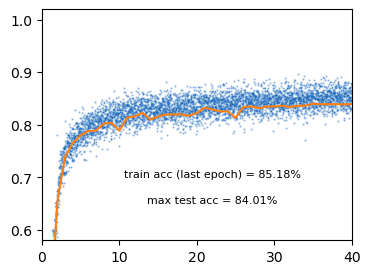

  0%|          | 0/40 [00:00<?, ?it/s]

train accuracies (last epoch): [0.851805261299435]
test accuracies: [0.8400735294117647]


In [8]:
fashion_model_width = 8 # must be even for the number of parameters to match

fashion_linear_relu = LinearReLU(
    fashion_num_features, fashion_num_classes, width=fashion_model_width
)
fashion_linear_relu.tag = "fashion_linear_relu"

fashion_linear_maxplus = LinearMaxPlus(
    fashion_num_features, fashion_num_classes, width=fashion_model_width
)
fashion_linear_maxplus.tag = "fashion_linear_maxplus"

fashion_linear_minplus = LinearMinPlus(
    fashion_num_features, fashion_num_classes, width=fashion_model_width
)
fashion_linear_minplus.tag = "fashion_linear_minplus"

fashion_linear_logplus_m10 = LinearLogPlus(
    fashion_num_features, fashion_num_classes, width=fashion_model_width, mu=-10
)
fashion_linear_logplus_m10.tag = "fashion_linear_logplus_m10"

fashion_linear_logplus_m1 = LinearLogPlus(
    fashion_num_features, fashion_num_classes, width=fashion_model_width, mu=-1
)
fashion_linear_logplus_m1.tag = "fashion_linear_logplust_m1"

fashion_linear_logplus_p1 = LinearLogPlus(
    fashion_num_features, fashion_num_classes, width=fashion_model_width, mu=1
)
fashion_linear_logplus_p1.tag = "fashion_linear_logplust_p1"

fashion_linear_logplus_p10 = LinearLogPlus(
    fashion_num_features, fashion_num_classes, width=fashion_model_width, mu=10
)
fashion_linear_logplus_p10.tag = "fashion_linear_logplust_p10"

fashion_models = [
    #fashion_linear_relu,
    #fashion_linear_maxplus,
    #fashion_linear_minplus,
    fashion_linear_logplus_m10,
    #fashion_linear_logplus_m1,
    #fashion_linear_logplus_p1,
    #fashion_linear_logplus_p10,
]

fashion_models = [m.to(device) for m in fashion_models]

loss = nn.CrossEntropyLoss()
epochs = 40

fashion_train100accs = []
fashion_testaccs = []
for im, m in enumerate(fashion_models):
    optimizer, scheduler = m.get_optimizer_and_scheduler(epochs, len(fashion_train_loader))
    print(f"\n\nmodel = {m.tag}:")
    train100acc, testacc = train(
        m,
        device,
        fashion_train_loader,
        fashion_test_loader,
        optimizer,
        scheduler,
        loss,
        epochs
    )
    fashion_train100accs.append(train100acc)
    fashion_testaccs.append(testacc)

print(f"train accuracies (last epoch): {fashion_train100accs}")
print(f"test accuracies: {fashion_testaccs}")

In [9]:
for p in fashion_linear_logplus_m10.parameters():
    print(torch.isnan(p).any().item())

False
False
False
False
False
False
False
False
False
False


In [10]:
for p in fashion_linear_logplus_m10.parameters():
    print(p.grad)

tensor([[ 0.0164,  0.0163,  0.0159,  ...,  0.0109,  0.0178,  0.0165],
        [-0.0441, -0.0441, -0.0440,  ..., -0.0447, -0.0446, -0.0441],
        [-0.0057, -0.0057, -0.0056,  ..., -0.0033, -0.0061, -0.0058],
        ...,
        [ 0.0352,  0.0352,  0.0354,  ...,  0.0416,  0.0351,  0.0352],
        [ 0.0254,  0.0254,  0.0254,  ...,  0.0240,  0.0257,  0.0254],
        [-0.0183, -0.0183, -0.0181,  ..., -0.0216, -0.0199, -0.0184]],
       device='cuda:0')
tensor([-0.1650, -0.0866,  0.0769, -0.0913,  0.0452,  0.0302, -0.0632,  0.0280],
       device='cuda:0')
tensor([-0.1720, -0.0061,  0.0088,  0.0925,  0.0464, -0.1393, -0.0269,  0.2207],
       device='cuda:0')
tensor([[-0.0193, -0.0147, -0.1598, -0.0373,  0.0190, -0.0114,  0.0273,  0.0349],
        [ 0.0407,  0.0403,  0.0832, -0.0266, -0.0416,  0.0017,  0.0083, -0.0127],
        [-0.0043, -0.0439, -0.0709,  0.0280,  0.0113,  0.0490, -0.0678,  0.0457],
        [-0.0171,  0.0183,  0.1475,  0.0358,  0.0113, -0.0392,  0.0322, -0.0679]],
   